# SFO Survey Machine Learning Example
Each year, San Francisco Airport (SFO) conducts a customer satisfaction survey to find out what they are doing well and where they can improve. The survey gauges satisfaction with SFO facilities, services, and amenities. SFO compares results to previous surveys to discover elements of the guest experience that are not satisfactory.

The 2013 SFO Survey Results consists of customer responses to survey questions and an overall satisfaction rating with the airport. We investigated whether we could use machine learning to predict a customer's overall response given their responses to the individual questions. That in and of itself is not very useful because the customer has already provided an overall rating as well as individual ratings for various aspects of the airport such as parking, food quality and restroom cleanliness. However, we didn't stop at prediction instead we asked the question:

In [1]:
url='https://data.sfgov.org/api/views/3w8r-nuxp/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B'

In [2]:
from pyspark import SparkFiles
from pyspark.sql.types import *
import pyspark.sql.functions as f
 
import pandas as pd
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('SFO Survey').getOrCreate()
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [3]:
spark.sparkContext.addFile(url)

In [9]:
dataset = spark.read.option("header","true").option("inferSchema","true").csv("file://"+SparkFiles.get("rows.csv"),sep=";")
cols = dataset.columns

In [10]:
display(dataset)

RESPNUM,CCGID,RUNID,INTDATE,DAY,GATE,BAREA,STRATA,PEAK,METH,SAQ,AIRLINE,DESTINATION,FLIGHT,AIRLINE_CODE,DEST_CODE,DESTGEO,DESTMARK,ARRTIME,DEPTIME,Q2PURP1,Q2PURP2,Q2PURP3,Q3GETTO1,Q3GETTO2,Q3GETTO3,Q3PARK,Q4BAGS,Q4STORE,Q4FOOD,Q4WIFI,Q5TIMESFLOWN,Q5FIRSTTIME,Q6LONGUSE,Q7ART,Q7FOOD,Q7STORE,Q7SIGN,Q7WALKWAY,Q7SCREENS,Q7INFODOWN,Q7INFOUP,Q7WIFI,Q7ROADS,Q7PARK,Q7AIRTRAIN,Q7LTPARKING,Q7RENTAL,Q7ALL,Q8-1,Q8-2,Q8-3,Q8-4,Q8-5,Q8-6,Q9Boarding,Q9AirTrain,Q9Rental,Q9Food,Q9Restroom,Q9All,Q9-1,Q9-2,Q9-3,Q10Safe,Q10-1,Q10-2,Q10-3,Q11TSAPRE,Q12PRECHECKRATE,Q12-1,Q12-2,Q12-3,Q13COUNTY,Q13GETRATE,Q14FIND,Q14PASSTHRU,Q15PROBLEM,Q15A,Q15-1,Q15-2,Q15-3,NETPRO,Q17LIVE,Q18COUNTY,Q18ZIP,Q18COUNTRY,HOME,Q19Clear,Q20Age,Q21Gender,Q22Income,Q23FLY,Q24SJC,Q24OAK,LANG,WEIGHT
"1,842","1,680",552,21,2,102,G,3,3,1,2,TURKISH AIRLINES,ISTANBUL,80,29,27,7,4,12/31/1899 02:00:...,12/31/1899 06:15:...,2,null,null,2,null,null,null,1,1,1,1,2,1,1,6,6,3,4,4,4,4,4,4,4,6,6,6,6,4,0,null,null,null,null,null,4,6,6,6,4,3,0,null,null,3,4,null,null,0,null,null,null,null,18,5,4,3,2,null,null,null,null,5,3,null,null,CYPRUS,15,2,6,2,0,0,2,2,1,0.6704842
"1,844","1,681",552,21,2,102,G,3,3,1,2,TURKISH AIRLINES,ISTANBUL,80,29,27,7,4,12/31/1899 01:00:...,12/31/1899 06:15:...,2,3,null,9,null,null,null,1,2,2,2,1,2,1,6,3,4,4,4,5,6,6,2,4,6,4,6,2,4,0,null,null,null,null,null,5,4,3,6,4,4,0,null,null,4,0,null,null,1,2,14,null,null,5,4,4,3,2,null,null,null,null,7,3,null,null,TURKEY,15,2,4,1,2,1,2,2,1,0.6704842
"1,840","1,678",552,21,2,102,G,3,3,1,1,TURKISH AIRLINES,ISTANBUL,80,29,27,7,4,12/31/1899 03:30:...,12/31/1899 06:15:...,5,null,null,7,null,null,null,3,3,3,1,1,2,3,3,6,4,4,6,4,3,3,5,6,6,6,6,6,4,0,null,null,null,null,null,4,6,6,6,2,3,0,null,null,4,0,null,null,1,3,0,null,null,0,4,5,3,2,null,null,null,null,7,3,null,null,TURKEY,15,1,5,1,5,2,2,2,1,0.6704842
"1,837","1,676",552,21,2,102,G,3,3,1,1,TURKISH AIRLINES,ISTANBUL,80,29,27,7,4,12/31/1899 02:30:...,12/31/1899 06:15:...,3,null,null,5,null,null,null,1,1,1,1,2,1,0,0,4,4,4,5,4,0,0,5,0,0,0,0,0,4,0,null,null,null,null,null,5,0,0,3,4,4,0,null,null,4,0,null,null,0,null,null,null,null,0,0,0,0,0,null,null,null,null,8,3,null,null,MACEDONIA,15,2,2,2,3,3,2,1,1,0.6704842
"1,833","1,674",552,21,2,102,G,3,3,1,2,TURKISH AIRLINES,ISTANBUL,80,29,27,7,4,12/31/1899 03:20:...,12/31/1899 06:15:...,4,null,null,2,null,null,null,1,2,0,2,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BLANK,11,null,null,null,null,null,5,6,6,4,5,5,1,null,null,3,1,null,null,0,null,null,null,null,0,3,3,3,1,I FLEW WITH TK A ...,31,null,null,8,3,null,null,GERMANY,15,2,2,2,2,2,2,2,1,0.6704842
"3,010","2,216",613,23,4,58,D,3,2,1,2,AMERICAN,MIAMI,556,8,37,2,4,12/31/1899 08:00:...,12/31/1899 09:28:...,1,null,null,5,null,null,null,2,0,1,2,1,2,1,3,4,3,3,3,3,6,3,6,6,6,6,6,6,4,0,null,null,null,null,null,5,6,6,4,0,4,0,null,null,5,0,null,null,0,null,null,null,null,5,4,5,3,2,null,null,null,null,8,3,MIAMI-DADE COUNTY,33146,US,12,1,4,2,4,3,2,2,1,1.0611394
"1,838","1,677",552,21,2,102,G,3,3,1,2,TURKISH AIRLINES,ISTANBUL,80,29,27,7,4,12/31/1899 03:00:...,12/31/1899 06:15:...,1,null,null,6,null,null,null,1,2,1,1,1,2,1,4,3,3,2,3,4,4,4,5,6,6,6,6,6,4,0,null,null,null,null,null,5,6,6,5,3,4,0,null,null,5,0,null,null,0,null,null,null,null,5,5,4,4,2,null,null,null,null,8,3,null,null,TURKEY,15,2,3,1,2,2,2,2,1,0.6704842
"1,845","1,682",552,21,2,102,G,3,3,1,2,TURKISH AIRLINES,ISTANBUL,80,29,27,7,4,12/31/1899 04:00:...,12/31/1899 06:15:...,2,null,null,3,null,null,null,2,2,2,1,1,0,1,3,6,6,4,4,4,6,6,4,6,6,6,6,6,4,0,null,null,null,null,null,4,6,6,6,3,3,0,null,null,4,0,null,null,4,null,null,null,null,11,6,4,6,2,null,null,null,null,8,3,CLARK COUNTY,98661,US,10,2,6,1,2,2,2,2,1,0.6704842
"2,097","1,705",557,21,2,98,G,3,3,1,2,UNITED INTL,MEXICO CITY,412,31,36,4,4,12/31/1899 08:45:...,12/31/1899 11:10:...,1,null,null,2,null,null,null,2,1,2,1,4,1,4,4,3,3,4,4,4,6,6,4,4,4,6,3,6,4,0,null,null,null,null,null,4,6,6,4,4,4,0,null,null,4,4,null,null,1,5,21,10,null,2,3,5,5,2,null,null,null,null,9,1,CONTRA COSTA COUNTY,94505,US,2,2,6,2,4,2,1

In [11]:
dataset.printSchema()

root
 |-- RESPNUM: string (nullable = true)
 |-- CCGID: string (nullable = true)
 |-- RUNID: integer (nullable = true)
 |-- INTDATE: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- GATE: integer (nullable = true)
 |-- BAREA: string (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- PEAK: integer (nullable = true)
 |-- METH: integer (nullable = true)
 |-- SAQ: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- DESTINATION: string (nullable = true)
 |-- FLIGHT: string (nullable = true)
 |-- AIRLINE_CODE: integer (nullable = true)
 |-- DEST_CODE: integer (nullable = true)
 |-- DESTGEO: integer (nullable = true)
 |-- DESTMARK: integer (nullable = true)
 |-- ARRTIME: string (nullable = true)
 |-- DEPTIME: string (nullable = true)
 |-- Q2PURP1: integer (nullable = true)
 |-- Q2PURP2: integer (nullable = true)
 |-- Q2PURP3: integer (nullable = true)
 |-- Q3GETTO1: integer (nullable = true)
 |-- Q3GETTO2: integer (nullable = true)
 |-- Q3GETTO3:

As you can see above there are many questions in the survey including what airline the customer flew on, where do they live, etc. For the purposes of answering the above, focus on the Q7A, Q7B, Q7C .. Q7O questions since they directly related to customer satisfaction, which is what you want to measure. If you drill down on those variables you get the following:

|Column Name	|Data Type	|Description|
|---------------|-----------|-----------|
|Q7FOOD|INTEGER|Restaurants|
|Q7STORE|INTEGER|Retail shops and concessions||
|Q7SIGN|INTEGER|Signs and Directions inside SFO|
|Q7WALKWAY|INTEGER|Escalators / elevators / moving walkways|
|Q7SCREENS|INTEGER|Information on screens and monitors|
|Q7INFODOWN|INTEGER|Information booth near arrivals area|
|Q7INFOUP|INTEGER|Information booth near departure areas|
|Q7WIFI|INTEGER|Airport WiFi|
|Q7ROADS|INTEGER|Signs and directions on SFO airport roadways|
|Q7PARK|INTEGER|Airport parking facilities|
|Q7AIRTRAIN|INTEGER|AirTrain|
|Q7LTPARKING|INTEGER|Long term parking lot shuttle|
|Q7RENTAL|INTEGER|Airport rental car center|
|Q7ALL|INTEGER|SFO Airport as a whole|

The possible values for the above are:

0 = no answer, 1 = Unacceptable, 2 = Below Average, 3 = Average, 4 = Good, 5 = Outstanding, 6 = Not visited or not applicable

Select only the fields you are interested in.

In [22]:
dataset = dataset.select(*[ c for c in cols if c.startswith('Q7')])

In [25]:
a = map(lambda s: "'avg(" + s +") " + s + "'",dataset.columns)
", ".join(a)

"'avg(Q7ART) Q7ART', 'avg(Q7FOOD) Q7FOOD', 'avg(Q7STORE) Q7STORE', 'avg(Q7SIGN) Q7SIGN', 'avg(Q7WALKWAY) Q7WALKWAY', 'avg(Q7SCREENS) Q7SCREENS', 'avg(Q7INFODOWN) Q7INFODOWN', 'avg(Q7INFOUP) Q7INFOUP', 'avg(Q7WIFI) Q7WIFI', 'avg(Q7ROADS) Q7ROADS', 'avg(Q7PARK) Q7PARK', 'avg(Q7AIRTRAIN) Q7AIRTRAIN', 'avg(Q7LTPARKING) Q7LTPARKING', 'avg(Q7RENTAL) Q7RENTAL', 'avg(Q7ALL) Q7ALL'"

In [26]:
avgs = dataset.selectExpr('avg(Q7ART) Q7ART', 'avg(Q7FOOD) Q7FOOD', 'avg(Q7STORE) Q7STORE', 'avg(Q7SIGN) Q7SIGN', 'avg(Q7WALKWAY) Q7WALKWAY', 'avg(Q7SCREENS) Q7SCREENS', 'avg(Q7INFODOWN) Q7INFODOWN', 'avg(Q7INFOUP) Q7INFOUP', 'avg(Q7WIFI) Q7WIFI', 'avg(Q7ROADS) Q7ROADS', 'avg(Q7PARK) Q7PARK', 'avg(Q7AIRTRAIN) Q7AIRTRAIN', 'avg(Q7LTPARKING) Q7LTPARKING', 'avg(Q7RENTAL) Q7RENTAL', 'avg(Q7ALL) Q7ALL')
display(avgs)

Q7ART,Q7FOOD,Q7STORE,Q7SIGN,Q7WALKWAY,Q7SCREENS,Q7INFODOWN,Q7INFOUP,Q7WIFI,Q7ROADS,Q7PARK,Q7AIRTRAIN,Q7LTPARKING,Q7RENTAL,Q7ALL
4.159487362050552,3.7689569241723033,3.747953008187967,3.9348522605909575,4.086151655393379,3.995372018511926,4.527233891064435,4.487006051975792,4.232111071555714,4.3203987184051265,4.729441082235671,4.6511213955144175,4.99003203987184,4.803488786044856,4.002666666666666


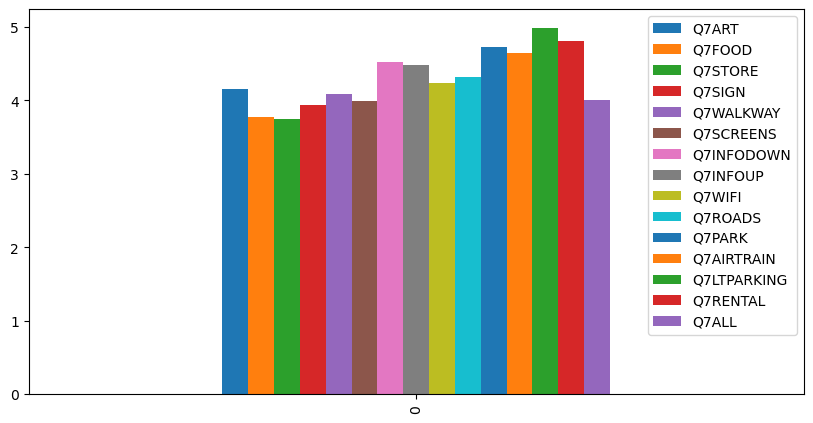

In [42]:
import matplotlib.pyplot as plt
avgs.toPandas().plot(kind='bar',figsize=(10,5))
plt.show()

So basic statistics can't seem to answer the question: What factors drove the customer to give the overall rating?

So let's try to use a predictive algorithm to see if these individual ratings can be used to predict an overall rating.

## Create Model
Here use a decision tree algorithm to create a predictive model.

First need to treat responses of 0 = No Answer and 6 = Not Visited or Not Applicable as missing values. One of the ways you can do this is a technique called mean impute which is when we use the mean of the column as a replacement for the missing value. You can use a replace function to set all values of 0 or 6 to the average rating of 3. You also need a label column of type double so do that as well.

In [54]:
training = dataset.withColumn("label", dataset['Q7ALL']*1.0).na.fill(value=0).replace(0,3).replace(6,3).drop('Q7ALL')
display(training)

Q7ART,Q7FOOD,Q7STORE,Q7SIGN,Q7WALKWAY,Q7SCREENS,Q7INFODOWN,Q7INFOUP,Q7WIFI,Q7ROADS,Q7PARK,Q7AIRTRAIN,Q7LTPARKING,Q7RENTAL,label
3,3,3,4,4,4,4,4,4,4,3,3,3,3,4.0
3,3,4,4,4,5,3,3,2,4,3,4,3,2,4.0
3,3,4,4,3,4,3,3,5,3,3,3,3,3,4.0
3,4,4,4,5,4,3,3,5,3,3,3,3,3,4.0
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3.0
3,4,3,3,3,3,3,3,3,3,3,3,3,3,4.0
4,3,3,2,3,4,4,4,5,3,3,3,3,3,4.0
3,3,3,4,4,4,3,3,4,3,3,3,3,3,4.0
4,3,3,4,4,4,3,3,4,4,4,3,3,3,4.0
3,4,3,4,3,4,3,3,2,3,2,2,2,2,4.0


In [56]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
 
inputCols = training.columns[:-1]

va = VectorAssembler(inputCols=inputCols,outputCol="features")
dt = DecisionTreeRegressor(labelCol="label", featuresCol="features", maxDepth=4)
evaluator = RegressionEvaluator(metricName = "rmse", labelCol="label")
grid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 7, 10]).build()
cv = CrossValidator(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator, numFolds = 10)
pipeline = Pipeline(stages=[va, dt])

In [57]:
model = pipeline.fit(training)

In [58]:
display(model.stages[-1])

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_4b6fc452f34e, depth=4, numNodes=31, numFeatures=14

In [59]:
predictions = model.transform(training)
display(predictions)

Q7ART,Q7FOOD,Q7STORE,Q7SIGN,Q7WALKWAY,Q7SCREENS,Q7INFODOWN,Q7INFOUP,Q7WIFI,Q7ROADS,Q7PARK,Q7AIRTRAIN,Q7LTPARKING,Q7RENTAL,label,features,prediction
3,3,3,4,4,4,4,4,4,4,3,3,3,3,4.0,"[3.0,3.0,3.0,4.0,...",3.807531380753138
3,3,4,4,4,5,3,3,2,4,3,4,3,2,4.0,"[3.0,3.0,4.0,4.0,...",3.807531380753138
3,3,4,4,3,4,3,3,5,3,3,3,3,3,4.0,"[3.0,3.0,4.0,4.0,...",3.807531380753138
3,4,4,4,5,4,3,3,5,3,3,3,3,3,4.0,"[3.0,4.0,4.0,4.0,...",3.807531380753138
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3.0,"[3.0,3.0,3.0,3.0,...",3.34032634032634
3,4,3,3,3,3,3,3,3,3,3,3,3,3,4.0,"[3.0,4.0,3.0,3.0,...",3.34032634032634
4,3,3,2,3,4,4,4,5,3,3,3,3,3,4.0,"[4.0,3.0,3.0,2.0,...",4.070967741935484
3,3,3,4,4,4,3,3,4,3,3,3,3,3,4.0,"[3.0,3.0,3.0,4.0,...",3.807531380753138
4,3,3,4,4,4,3,3,4,4,4,3,3,3,4.0,"[4.0,3.0,3.0,4.0,...",4.070967741935484
3,4,3,4,3,4,3,3,2,3,2,2,2,2,4.0,"[3.0,4.0,3.0,4.0,...",3.807531380753138


In [64]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import * 
 
evaluator = RegressionEvaluator()
 
evaluator.evaluate(predictions.withColumn('prediction', round(col('prediction'))), {evaluator.metricName: "rmse"})

0.6305952817761662

In [65]:
model.stages[1].featureImportances

SparseVector(14, {0: 0.0694, 1: 0.1365, 2: 0.0366, 3: 0.5505, 4: 0.0031, 5: 0.1809, 10: 0.0166, 12: 0.0065})

In [66]:
featureImportance = model.stages[1].featureImportances.toArray()
featureNames = map(lambda s: s.name, dataset.schema.fields)
featureImportanceMap = zip(featureImportance, featureNames)

In [68]:
importancesDf = spark.createDataFrame(spark.sparkContext.parallelize(featureImportanceMap).map(lambda r: [r[1], float(r[0])]))
importancesDf = importancesDf.withColumnRenamed("_1", "Feature").withColumnRenamed("_2", "Importance")
display(importancesDf.orderBy(desc("Importance")))

Feature,Importance
Q7SIGN,0.5504690497103084
Q7SCREENS,0.18093490191263886
Q7FOOD,0.13652080272942918
Q7ART,0.0694055570462642
Q7STORE,0.03656774137077657
Q7PARK,0.016554999116558958
Q7LTPARKING,0.006463821484460761
Q7WALKWAY,0.003083126629562986
Q7ROADS,0.0
Q7INFOUP,0.0


As you can see below, the 3 most important features are:

- Signs
- Screens
- Food

This is useful information for the airport management. It means that people want to first know where they are going. Second, they check the airport screens and monitors so they can find their gate and be on time for their flight. Third, they like to have good quality food.

This is especially interesting considering that taking the average of these feature variables told us nothing about the importance of the variables in determining the overall rating by the survey responder.

These 3 features combine to make up 86% of the overall rating.

In [70]:
importancesDf.orderBy(desc("Importance")).limit(3).agg(sum("Importance")).take(1)

[Row(sum(Importance)=0.8679247543523765)]

<AxesSubplot: xlabel='Feature'>

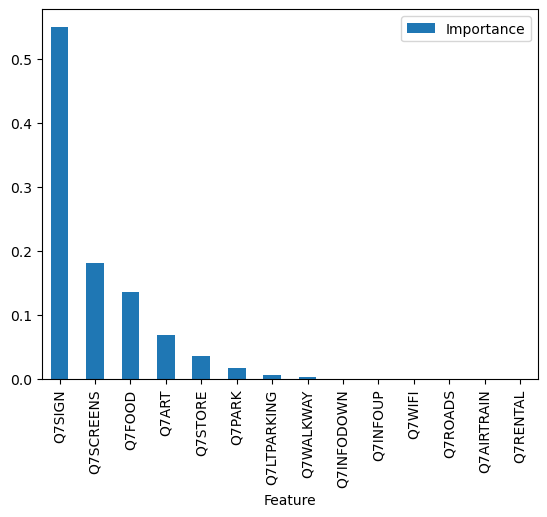

In [72]:
importancesDf.orderBy(desc("Importance")).toPandas().plot(x="Feature",kind="bar")